<a href="https://colab.research.google.com/github/mildsupitcha25/MachineLearning_phishing_email/blob/main/ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#XGBoost

In [5]:
# ==============================
# 1. Import Libraries
# ==============================
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier

# ==============================
# 2. Load Data
# ==============================
TRAIN_URL = 'https://raw.githubusercontent.com/mildsupitcha25/MachineLearning_phishing_email/main/train.csv'
TEST_URL = 'https://raw.githubusercontent.com/mildsupitcha25/MachineLearning_phishing_email/main/test.csv'

print("กำลังโหลดข้อมูลจาก GitHub...")
try:
    train_df = pd.read_csv(TRAIN_URL)
    test_df = pd.read_csv(TEST_URL)
    print("โหลดข้อมูลสำเร็จ!")
except Exception as e:
    print(f"เกิดข้อผิดพลาดในการโหลดข้อมูล: {e}")
    exit()

print(f"Train Shape: {train_df.shape}")
print(f"Test Shape: {test_df.shape}")
print(f"Train Columns: {list(train_df.columns)}")

# ==============================
# 3. Data Preparation
# ==============================
train_df['FullText'] = train_df['Subject'].fillna('') + ' ' + train_df['Body'].fillna('')
test_df['FullText'] = test_df['Subject'].fillna('') + ' ' + test_df['Body'].fillna('')

TEXT_COLUMN = 'FullText'
TARGET_COLUMN_STR = 'Label'

label_mapping = {'Legitimate': 0, 'Phishing': 1}
train_df['label_num'] = train_df[TARGET_COLUMN_STR].map(label_mapping)

X_train = train_df[TEXT_COLUMN].fillna('')
y_train = train_df['label_num']
X_test = test_df[TEXT_COLUMN].fillna('')

# ==============================
# 4. TF-IDF Vectorization
# ==============================
vectorizer = TfidfVectorizer(stop_words='english', lowercase=True, max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print(f"TF-IDF Train Shape: {X_train_vec.shape}")

# ==============================
# 5. Train/Validation Split
# ==============================
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_vec, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# ==============================
# 6. Hyperparameter Tuning (RandomizedSearchCV)
# ==============================
param_dist = {
    'n_estimators': [200, 500, 800, 1000],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]
}

xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=20,              # จำนวนรอบสุ่ม
    scoring='accuracy',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

print("\nกำลังทำ Hyperparameter Tuning ด้วย RandomizedSearchCV...")
random_search.fit(X_train_split, y_train_split)

best_xgb_model = random_search.best_estimator_
print("\nBest Parameters:", random_search.best_params_)

# ==============================
# 7. Evaluate Model
# ==============================
y_val_pred = best_xgb_model.predict(X_val_split)
print("\nValidation Accuracy:", accuracy_score(y_val_split, y_val_pred))
print(classification_report(y_val_split, y_val_pred))

# ==============================
# 8. Predict Test Set
# ==============================
y_pred = best_xgb_model.predict(X_test_vec)

submission_df = test_df.copy()
submission_df['Predicted_Label_Num'] = y_pred
reverse_label_mapping = {v: k for k, v in label_mapping.items()}
submission_df['Predicted_Label'] = submission_df['Predicted_Label_Num'].map(reverse_label_mapping)

# เลือกคอลัมน์สำหรับแสดงผล
if 'Id' in test_df.columns:
    output_cols = ['Id', 'Predicted_Label']
elif 'ID' in test_df.columns:
    output_cols = ['ID', 'Predicted_Label']
else:
    submission_df['Index'] = submission_df.index
    output_cols = ['Index', 'Predicted_Label']

final_submission = submission_df[output_cols]

# ✅ แสดงผลลัพธ์ตรง ๆ โดยไม่ดาวน์โหลดไฟล์
print("\n--- ผลลัพธ์การทำนาย (20 แถวแรก) ---")
print(final_submission.head(20))
print("\nจำนวนทั้งหมด:", len(final_submission))

กำลังโหลดข้อมูลจาก GitHub...
โหลดข้อมูลสำเร็จ!
Train Shape: (100, 3)
Test Shape: (26, 3)
Train Columns: ['Subject', 'Body', 'Label']
TF-IDF Train Shape: (100, 2616)

กำลังทำ Hyperparameter Tuning ด้วย RandomizedSearchCV...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best Parameters: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}

Validation Accuracy: 0.95
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.91      1.00      0.95        10

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.95      0.95      0.95        20


--- ผลลัพธ์การทำนาย (20 แถวแรก) ---
    Index Predicted_Label
0       0      Legitimate
1       1        Phishing
2       2        Phishing
3       3        Phishing
4       4      Legitimate
5  

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [14:40:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


#Naive Bayes

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# ✅ ใช้ลิงก์ raw file
traindata = 'https://raw.githubusercontent.com/mildsupitcha25/MachineLearning_phishing_email/main/train.csv'

try:
    df = pd.read_csv(traindata)

    # ✅ ตรวจสอบคอลัมน์
    print("คอลัมน์ที่มีอยู่:", df.columns.tolist())

    # ✅ ถ้าชื่อคอลัมน์ไม่ตรง ให้แก้
    if 'Subject' not in df.columns or 'Label' not in df.columns:
        # ตัวอย่างการแก้ชื่อคอลัมน์
        # df.rename(columns={'Email_Content': 'Subject', 'Category': 'Label'}, inplace=True)
        raise ValueError("คอลัมน์ Subject หรือ Label ไม่พบในไฟล์ CSV")

    # ✅ แปลง Label เป็นตัวเลข
    if df['Label'].dtype == object:
        df['Label_num'] = df['Label'].map({'Legitimate': 0, 'Phishing': 1})
    else:
        df['Label_num'] = df['Label']

    X = df['Subject']
    y = df['Label_num']
    print(f"โหลดข้อมูลสำเร็จ. จำนวนอีเมล: {len(df)}")

except Exception as e:
    print(f"เกิดข้อผิดพลาดในการโหลดข้อมูล: {e}")

# ✅ แบ่งข้อมูล
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# ✅ TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', lowercase=True)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# ✅ โมเดล Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train)

# ✅ ประเมินผล
y_pred = nb_model.predict(X_test_vec)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=['Legitimate', 'Phishing']))

คอลัมน์ที่มีอยู่: ['Subject', 'Body', 'Label']
โหลดข้อมูลสำเร็จ. จำนวนอีเมล: 100
Accuracy: 0.7666666666666667
Confusion Matrix:
 [[10  5]
 [ 2 13]]
Classification Report:
               precision    recall  f1-score   support

  Legitimate       0.83      0.67      0.74        15
    Phishing       0.72      0.87      0.79        15

    accuracy                           0.77        30
   macro avg       0.78      0.77      0.76        30
weighted avg       0.78      0.77      0.76        30



In [6]:
# ==============================
# 1. Import Libraries
# ==============================
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# ==============================
# 2. Load Data
# ==============================
TRAIN_URL = 'https://raw.githubusercontent.com/mildsupitcha25/MachineLearning_phishing_email/main/train.csv'
TEST_URL = 'https://raw.githubusercontent.com/mildsupitcha25/MachineLearning_phishing_email/main/test.csv'

print("กำลังโหลดข้อมูลจาก GitHub...")
try:
    train_df = pd.read_csv(TRAIN_URL)
    test_df = pd.read_csv(TEST_URL)
    print("โหลดข้อมูลสำเร็จ!")
except Exception as e:
    print(f"เกิดข้อผิดพลาดในการโหลดข้อมูล: {e}")
    exit()

print(f"Train Shape: {train_df.shape}")
print(f"Test Shape: {test_df.shape}")
print(f"Train Columns: {list(train_df.columns)}")

# ==============================
# 3. Data Preparation
# ==============================
train_df['FullText'] = train_df['Subject'].fillna('') + ' ' + train_df['Body'].fillna('')
test_df['FullText'] = test_df['Subject'].fillna('') + ' ' + test_df['Body'].fillna('')

TEXT_COLUMN = 'FullText'
TARGET_COLUMN_STR = 'Label'

label_mapping = {'Legitimate': 0, 'Phishing': 1}
train_df['label_num'] = train_df[TARGET_COLUMN_STR].map(label_mapping)

X_train = train_df[TEXT_COLUMN].fillna('')
y_train = train_df['label_num']
X_test = test_df[TEXT_COLUMN].fillna('')

# ==============================
# 4. TF-IDF Vectorization
# ==============================
vectorizer = TfidfVectorizer(stop_words='english', lowercase=True, max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print(f"TF-IDF Train Shape: {X_train_vec.shape}")

# ==============================
# 5. Train/Validation Split
# ==============================
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_vec, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# ==============================
# 6. Hyperparameter Tuning (RandomizedSearchCV)
# ==============================
param_dist = {
    'alpha': [0.1, 0.5, 1.0, 2.0, 5.0],  # smoothing parameter
    'fit_prior': [True, False]
}

nb_model = MultinomialNB()

random_search = RandomizedSearchCV(
    estimator=nb_model,
    param_distributions=param_dist,
    n_iter=5,              # จำนวนรอบสุ่ม
    scoring='accuracy',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

print("\nกำลังทำ Hyperparameter Tuning ด้วย RandomizedSearchCV...")
random_search.fit(X_train_split, y_train_split)

best_nb_model = random_search.best_estimator_
print("\nBest Parameters:", random_search.best_params_)

# ==============================
# 7. Evaluate Model
# ==============================
y_val_pred = best_nb_model.predict(X_val_split)
print("\nValidation Accuracy:", accuracy_score(y_val_split, y_val_pred))
print(classification_report(y_val_split, y_val_pred))

# ==============================
# 8. Predict Test Set
# ==============================
y_pred = best_nb_model.predict(X_test_vec)

submission_df = test_df.copy()
submission_df['Predicted_Label_Num'] = y_pred
reverse_label_mapping = {v: k for k, v in label_mapping.items()}
submission_df['Predicted_Label'] = submission_df['Predicted_Label_Num'].map(reverse_label_mapping)

# เลือกคอลัมน์สำหรับแสดงผล
if 'Id' in test_df.columns:
    output_cols = ['Id', 'Predicted_Label']
elif 'ID' in test_df.columns:
    output_cols = ['ID', 'Predicted_Label']
else:
    submission_df['Index'] = submission_df.index
    output_cols = ['Index', 'Predicted_Label']

final_submission = submission_df[output_cols]

# ✅ แสดงผลลัพธ์ตรง ๆ โดยไม่ดาวน์โหลดไฟล์
print("\n--- ผลลัพธ์การทำนาย (20 แถวแรก) ---")
print(final_submission.head(20))
print("\nจำนวนทั้งหมด:", len(final_submission))

กำลังโหลดข้อมูลจาก GitHub...
โหลดข้อมูลสำเร็จ!
Train Shape: (100, 3)
Test Shape: (26, 3)
Train Columns: ['Subject', 'Body', 'Label']
TF-IDF Train Shape: (100, 2616)

กำลังทำ Hyperparameter Tuning ด้วย RandomizedSearchCV...
Fitting 3 folds for each of 5 candidates, totalling 15 fits

Best Parameters: {'fit_prior': False, 'alpha': 0.1}

Validation Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20


--- ผลลัพธ์การทำนาย (20 แถวแรก) ---
    Index Predicted_Label
0       0      Legitimate
1       1      Legitimate
2       2      Legitimate
3       3        Phishing
4       4      Legitimate
5       5        Phishing
6       6      Legitimate
7       7      Legitimate
8       8        Phishing
9       9     

# เพิ่ม SMOTE ใน Naive Bayes Pipeline

In [11]:
# ==============================
# 1. Import Libraries
# ==============================
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

# ==============================
# 2. Load Data
# ==============================
TRAIN_URL = 'https://raw.githubusercontent.com/mildsupitcha25/MachineLearning_phishing_email/main/train.csv'
TEST_URL = 'https://raw.githubusercontent.com/mildsupitcha25/MachineLearning_phishing_email/main/test_generated.csv'  # ✅ ใช้ไฟล์ที่สร้างใหม่

print("กำลังโหลดข้อมูล...")
train_df = pd.read_csv(TRAIN_URL)
test_df = pd.read_csv(TEST_URL)
print("โหลดข้อมูลสำเร็จ!")
print(f"Train Shape: {train_df.shape}, Test Shape: {test_df.shape}")

# ==============================
# 3. Data Preparation
# ==============================
train_df['FullText'] = train_df['Subject'].fillna('') + ' ' + train_df['Body'].fillna('')
test_df['FullText'] = test_df['Subject'].fillna('') + ' ' + test_df['Body'].fillna('')

label_mapping = {'Legitimate': 0, 'Phishing': 1}
train_df['label_num'] = train_df['Label'].map(label_mapping)

X = train_df['FullText']
y = train_df['label_num']
X_test = test_df['FullText']

# ==============================
# 4. TF-IDF Vectorization
# ==============================
vectorizer = TfidfVectorizer(stop_words='english', lowercase=True, max_features=5000)
X_vec = vectorizer.fit_transform(X)
X_test_vec = vectorizer.transform(X_test)

# ==============================
# 5. Train/Validation Split
# ==============================
X_train, X_val, y_train, y_val = train_test_split(X_vec, y, test_size=0.2, random_state=42, stratify=y)

# ==============================
# 6. Apply SMOTE
# ==============================
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("ก่อน SMOTE:", y_train.value_counts().to_dict())
print("หลัง SMOTE:", pd.Series(y_train_resampled).value_counts().to_dict())

# ==============================
# 7. Train Naive Bayes Model
# ==============================
nb_model = MultinomialNB(alpha=0.1)
nb_model.fit(X_train_resampled, y_train_resampled)

# ==============================
# 8. Evaluate on Validation Set
# ==============================
y_val_pred = nb_model.predict(X_val)
print("\nValidation Accuracy:", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred, target_names=['Legitimate', 'Phishing']))

# ==============================
# 9. Predict Test Set
# ==============================
y_test_pred = nb_model.predict(X_test_vec)
test_df['Predicted_Label_Num'] = y_test_pred
reverse_label_mapping = {v: k for k, v in label_mapping.items()}
test_df['Predicted_Label'] = test_df['Predicted_Label_Num'].map(reverse_label_mapping)

print("\n--- ผลลัพธ์การทำนาย Test Set (20 แถวแรก) ---")
print(test_df[['Subject', 'Predicted_Label']].head(20))

กำลังโหลดข้อมูล...
โหลดข้อมูลสำเร็จ!
Train Shape: (100, 3), Test Shape: (50, 3)
ก่อน SMOTE: {0: 40, 1: 40}
หลัง SMOTE: {0: 40, 1: 40}

Validation Accuracy: 1.0
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00        10
    Phishing       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20


--- ผลลัพธ์การทำนาย Test Set (20 แถวแรก) ---
                            Subject Predicted_Label
0      Your account needs attention        Phishing
1                   Lunch tomorrow?        Phishing
2     Invoice for your recent order        Phishing
3                  Shipping details      Legitimate
4      Your account needs attention        Phishing
5            Urgent: Account locked        Phishing
6   Reset your password immediately        Phishing
7          Security alert from bank        Phishing

# เพิ่ม ROC/AUC

กำลังโหลดข้อมูล...
โหลดข้อมูลสำเร็จ!
Train Shape: (100, 3), Test Shape: (50, 3)
ก่อน SMOTE: {0: 40, 1: 40}
หลัง SMOTE: {0: 40, 1: 40}

Validation Accuracy: 1.0
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00        10
    Phishing       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

AUC Score: 1.0000


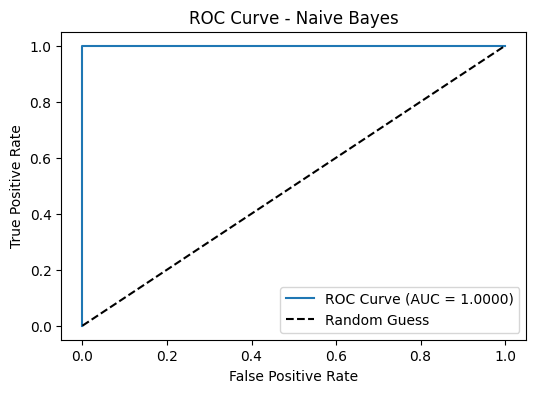


--- ผลลัพธ์การทำนาย Test Set (20 แถวแรก) ---
                                Subject Predicted_Label
0                Invoice for last month        Phishing
1             Follow-up on your request        Phishing
2             Follow-up on your request        Phishing
3             Your subscription details        Phishing
4      Your account might be restricted        Phishing
5           Quick update on the project      Legitimate
6             Follow-up on your request        Phishing
7       Reset your password to continue      Legitimate
8                   Ticket confirmation        Phishing
9          Password change confirmation        Phishing
10     Confirm your identity to proceed        Phishing
11              Dinner plans for Friday      Legitimate
12     Your account might be restricted        Phishing
13              Unlock your account now        Phishing
14      Update your billing information        Phishing
15  Your account will be suspended soon        Phishing
16

In [13]:
# ==============================
# 1. Import Libraries
# ==============================
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# ==============================
# 2. Load Data
# ==============================
TRAIN_URL = 'https://raw.githubusercontent.com/mildsupitcha25/MachineLearning_phishing_email/main/train.csv'
TEST_URL = 'https://raw.githubusercontent.com/mildsupitcha25/MachineLearning_phishing_email/main/test_generated_natural.csv'

print("กำลังโหลดข้อมูล...")
train_df = pd.read_csv(TRAIN_URL)
test_df = pd.read_csv(TEST_URL)
print("โหลดข้อมูลสำเร็จ!")
print(f"Train Shape: {train_df.shape}, Test Shape: {test_df.shape}")

# ==============================
# 3. Data Preparation
# ==============================
train_df['FullText'] = train_df['Subject'].fillna('') + ' ' + train_df['Body'].fillna('')
test_df['FullText'] = test_df['Subject'].fillna('') + ' ' + test_df['Body'].fillna('')

label_mapping = {'Legitimate': 0, 'Phishing': 1}
train_df['label_num'] = train_df['Label'].map(label_mapping)

X = train_df['FullText']
y = train_df['label_num']
X_test = test_df['FullText']

# ==============================
# 4. TF-IDF Vectorization
# ==============================
vectorizer = TfidfVectorizer(stop_words='english', lowercase=True, max_features=5000)
X_vec = vectorizer.fit_transform(X)
X_test_vec = vectorizer.transform(X_test)

# ==============================
# 5. Train/Validation Split
# ==============================
X_train, X_val, y_train, y_val = train_test_split(X_vec, y, test_size=0.2, random_state=42, stratify=y)

# ==============================
# 6. Apply SMOTE
# ==============================
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("ก่อน SMOTE:", y_train.value_counts().to_dict())
print("หลัง SMOTE:", pd.Series(y_train_resampled).value_counts().to_dict())

# ==============================
# 7. Train Naive Bayes Model
# ==============================
nb_model = MultinomialNB(alpha=0.1)
nb_model.fit(X_train_resampled, y_train_resampled)

# ==============================
# 8. Evaluate on Validation Set
# ==============================
y_val_pred = nb_model.predict(X_val)
y_val_prob = nb_model.predict_proba(X_val)[:, 1]  # Probability for class 1 (Phishing)

print("\nValidation Accuracy:", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred, target_names=['Legitimate', 'Phishing']))

# ✅ Calculate AUC
auc_score = roc_auc_score(y_val, y_val_prob)
print(f"AUC Score: {auc_score:.4f}")

# ✅ Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, y_val_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Naive Bayes')
plt.legend()
plt.show()

# ==============================
# 9. Predict Test Set
# ==============================
y_test_pred = nb_model.predict(X_test_vec)
test_df['Predicted_Label_Num'] = y_test_pred
reverse_label_mapping = {v: k for k, v in label_mapping.items()}
test_df['Predicted_Label'] = test_df['Predicted_Label_Num'].map(reverse_label_mapping)

print("\n--- ผลลัพธ์การทำนาย Test Set (20 แถวแรก) ---")
print(test_df[['Subject', 'Predicted_Label']].head(20))

#  โค้ดสมบูรณ์: Naive Bayes + SMOTE + Cross-validation + AUC/ROC + Predict Test Set


กำลังโหลดข้อมูล...
โหลดข้อมูลสำเร็จ!
Train Shape: (100, 3), Test Shape: (26, 3)
ก่อน SMOTE: {0: 40, 1: 40}
หลัง SMOTE: {0: 40, 1: 40}

Cross-Validation Accuracy: 0.9600 ± 0.0374
Cross-Validation AUC: 1.0000 ± 0.0000

Validation Accuracy: 1.0
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00        10
    Phishing       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

AUC Score: 1.0000


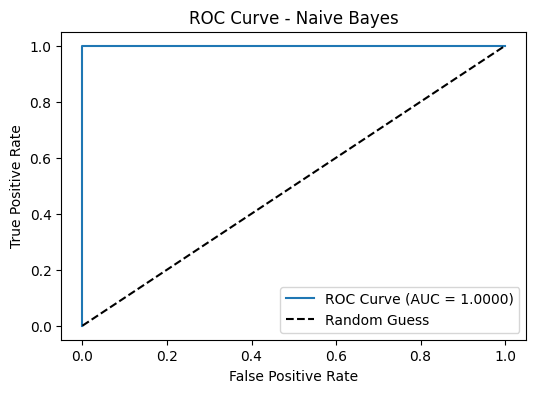


--- ผลลัพธ์การทำนาย Test Set (20 แถวแรก) ---
                                              Subject Predicted_Label
0   Exclusive Personal Relationship Opportunity Ju...      Legitimate
1   Exceptional Work-From-Home Job Opportunity Awa...      Legitimate
2   Notification of Recent Account Activity - Acti...      Legitimate
3   Exciting Work-from-Home Job Opportunity: Immed...        Phishing
4   Exclusive Promotional Offer Just for You, Lind...      Legitimate
5   Exclusive Promotional Offer from "Dynamic Glob...        Phishing
6   Exciting Job Opportunity Awaits You at [Organi...      Legitimate
7   Fantastic Work-From-Home Opportunity at BellaN...      Legitimate
8   Urgent Update Required for Your Health Managem...        Phishing
9   Exciting Job Opportunity and Immediate Action ...      Legitimate
10        Immediate Job Opportunity at Tech Solutions        Phishing
11        Important Technical Update - Security Alert        Phishing
12  Important Account Notification - Please 

In [18]:
# ==============================
# 1. Import Libraries
# ==============================
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')  # ✅ ปิด Warning

# ==============================
# 2. Load Data
# ==============================
TRAIN_URL = 'https://raw.githubusercontent.com/mildsupitcha25/MachineLearning_phishing_email/main/train.csv'
TEST_URL = 'https://raw.githubusercontent.com/mildsupitcha25/MachineLearning_phishing_email/main/test.csv'

print("\nกำลังโหลดข้อมูล...")
train_df = pd.read_csv(TRAIN_URL)
test_df = pd.read_csv(TEST_URL)
print("โหลดข้อมูลสำเร็จ!")
print(f"Train Shape: {train_df.shape}, Test Shape: {test_df.shape}")

# ==============================
# 3. Data Preparation
# ==============================
train_df['FullText'] = train_df['Subject'].fillna('') + ' ' + train_df['Body'].fillna('')
test_df['FullText'] = test_df['Subject'].fillna('') + ' ' + test_df['Body'].fillna('')

label_mapping = {'Legitimate': 0, 'Phishing': 1}
train_df['label_num'] = train_df['Label'].map(label_mapping)

X = train_df['FullText']
y = train_df['label_num']
X_test = test_df['FullText']

# ==============================
# 4. TF-IDF Vectorization
# ==============================
vectorizer = TfidfVectorizer(stop_words='english', lowercase=True, max_features=5000, ngram_range=(1,2))
X_vec = vectorizer.fit_transform(X)
X_test_vec = vectorizer.transform(X_test)

# ==============================
# 5. Train/Validation Split + SMOTE
# ==============================
X_train, X_val, y_train, y_val = train_test_split(X_vec, y, test_size=0.2, random_state=42, stratify=y)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("ก่อน SMOTE:", y_train.value_counts().to_dict())
print("หลัง SMOTE:", pd.Series(y_train_resampled).value_counts().to_dict())

# ==============================
# 6. Cross-validation (Accuracy & AUC)
# ==============================
nb_model = MultinomialNB(alpha=0.5)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracy_scores = cross_val_score(nb_model, X_vec, y, cv=cv, scoring='accuracy')
auc_scores = cross_val_score(nb_model, X_vec, y, cv=cv, scoring='roc_auc')

print(f"\nCross-Validation Accuracy: {np.mean(accuracy_scores):.4f} ± {np.std(accuracy_scores):.4f}")
print(f"Cross-Validation AUC: {np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f}")

# ==============================
# 7. Train Final Model & ROC Curve
# ==============================
nb_model.fit(X_train_resampled, y_train_resampled)
y_val_pred = nb_model.predict(X_val)
y_val_prob = nb_model.predict_proba(X_val)[:, 1]

print("\nValidation Accuracy:", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred, target_names=['Legitimate', 'Phishing']))

auc_score = roc_auc_score(y_val, y_val_prob)
print(f"AUC Score: {auc_score:.4f}")

fpr, tpr, thresholds = roc_curve(y_val, y_val_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Naive Bayes')
plt.legend()
plt.show()

# ==============================
# 8. Predict Test Set
# ==============================
y_test_pred = nb_model.predict(X_test_vec)
test_df['Predicted_Label_Num'] = y_test_pred
reverse_label_mapping = {v: k for k, v in label_mapping.items()}
test_df['Predicted_Label'] = test_df['Predicted_Label_Num'].map(reverse_label_mapping)

print("\n--- ผลลัพธ์การทำนาย Test Set (20 แถวแรก) ---")
print(test_df[['Subject', 'Predicted_Label']].head(20))

# ✅ บันทึกผลลัพธ์
test_df[['Subject', 'Predicted_Label']].to_csv('test_predictions_nb.csv', index=False)
print("\n✅ บันทึกผลลัพธ์ในไฟล์: test_predictions_nb.csv")

#Random Forest

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_selection import SelectKBest, chi2

# ✅ ใช้ลิงก์ raw file ของ GitHub
traindata = 'https://raw.githubusercontent.com/mildsupitcha25/MachineLearning_phishing_email/main/train.csv'

# --- 1. โหลดข้อมูล ---
df = pd.read_csv(traindata)

# ✅ ตรวจสอบคอลัมน์
print("คอลัมน์ที่มีอยู่:", df.columns.tolist())

# ✅ ถ้าชื่อคอลัมน์ไม่ตรง ให้แก้
if 'Subject' not in df.columns or 'Label' not in df.columns:
    raise ValueError("คอลัมน์ Subject หรือ Label ไม่พบในไฟล์ CSV")

# ✅ แปลง Label เป็นตัวเลข
df['Label_num'] = df['Label'].map({'Legitimate': 0, 'Phishing': 1})

X = df['Subject']
y = df['Label_num']

print(f"โหลดข้อมูลสำเร็จ. จำนวนอีเมล: {len(df)}")

# --- 2. แบ่งข้อมูล ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# --- 3. TF-IDF ---
vectorizer = TfidfVectorizer(stop_words='english', lowercase=True, ngram_range=(1,2), max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# --- 4. Feature Selection (เลือกฟีเจอร์ที่สำคัญ) ---
selector = SelectKBest(chi2, k=2000)
X_train_sel = selector.fit_transform(X_train_vec, y_train)
X_test_sel = selector.transform(X_test_vec)

# --- 5. โมเดล RandomForest ---
rf_model = RandomForestClassifier(n_estimators=300, max_depth=None, random_state=42, class_weight='balanced')
rf_model.fit(X_train_sel, y_train)

# --- 6. ประเมินผล ---
y_pred = rf_model.predict(X_test_sel)
print("="*50)
print("✨ ผลลัพธ์การจำแนก Phishing ด้วย RandomForest ✨")
print("="*50)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=['Legitimate', 'Phishing']))

# --- 7. ทดสอบกับอีเมลใหม่ ---
new_email = ["Verify your account password now or it will be deleted.",
             "Just checking in on the report status, no rush."]
new_email_vec = vectorizer.transform(new_email)
new_email_sel = selector.transform(new_email_vec)
new_pred = rf_model.predict(new_email_sel)

print("\n--- การทำนายอีเมลใหม่ ---")
for i, pred in enumerate(new_pred):
    label = 'Phishing' if pred == 1 else 'Legitimate'
    print(f"อีเมล: '{new_email[i]}' -> ทำนายเป็น: {label}")


คอลัมน์ที่มีอยู่: ['Subject', 'Body', 'Label']
โหลดข้อมูลสำเร็จ. จำนวนอีเมล: 100


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=2000 is greater than n_features=396. All the features will be returned.
  warnings.warn(


✨ ผลลัพธ์การจำแนก Phishing ด้วย RandomForest ✨
Accuracy: 0.7667

Confusion Matrix:
 [[10  5]
 [ 2 13]]

Classification Report:
               precision    recall  f1-score   support

  Legitimate       0.83      0.67      0.74        15
    Phishing       0.72      0.87      0.79        15

    accuracy                           0.77        30
   macro avg       0.78      0.77      0.76        30
weighted avg       0.78      0.77      0.76        30


--- การทำนายอีเมลใหม่ ---
อีเมล: 'Verify your account password now or it will be deleted.' -> ทำนายเป็น: Phishing
อีเมล: 'Just checking in on the report status, no rush.' -> ทำนายเป็น: Phishing



กำลังโหลดข้อมูล...
โหลดข้อมูลสำเร็จ!
Train Shape: (100, 3), Test Shape: (26, 3)

Cross-Validation Accuracy: 0.9500 ± 0.0548
Cross-Validation AUC: 0.9940 ± 0.0080

Validation Accuracy: 1.0
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00        10
    Phishing       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

AUC Score: 1.0000


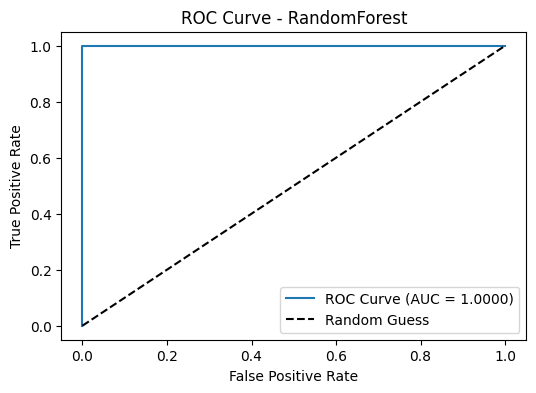


--- ผลลัพธ์การทำนาย Test Set (20 แถวแรก) ---
                                              Subject Predicted_Label
0   Exclusive Personal Relationship Opportunity Ju...      Legitimate
1   Exceptional Work-From-Home Job Opportunity Awa...      Legitimate
2   Notification of Recent Account Activity - Acti...      Legitimate
3   Exciting Work-from-Home Job Opportunity: Immed...        Phishing
4   Exclusive Promotional Offer Just for You, Lind...      Legitimate
5   Exclusive Promotional Offer from "Dynamic Glob...        Phishing
6   Exciting Job Opportunity Awaits You at [Organi...      Legitimate
7   Fantastic Work-From-Home Opportunity at BellaN...      Legitimate
8   Urgent Update Required for Your Health Managem...        Phishing
9   Exciting Job Opportunity and Immediate Action ...        Phishing
10        Immediate Job Opportunity at Tech Solutions        Phishing
11        Important Technical Update - Security Alert        Phishing
12  Important Account Notification - Please 

In [20]:
# ==============================
# 1. Import Libraries
# ==============================
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.feature_selection import SelectKBest, chi2
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')  # ✅ ปิด Warning

# ==============================
# 2. Load Data
# ==============================
TRAIN_URL = 'https://raw.githubusercontent.com/mildsupitcha25/MachineLearning_phishing_email/main/train.csv'
TEST_URL = 'https://raw.githubusercontent.com/mildsupitcha25/MachineLearning_phishing_email/main/test.csv'

print("\nกำลังโหลดข้อมูล...")
train_df = pd.read_csv(TRAIN_URL)
test_df = pd.read_csv(TEST_URL)
print("โหลดข้อมูลสำเร็จ!")
print(f"Train Shape: {train_df.shape}, Test Shape: {test_df.shape}")

# ==============================
# 3. Data Preparation
# ==============================
train_df['FullText'] = train_df['Subject'].fillna('') + ' ' + train_df['Body'].fillna('')
test_df['FullText'] = test_df['Subject'].fillna('') + ' ' + test_df['Body'].fillna('')

label_mapping = {'Legitimate': 0, 'Phishing': 1}
train_df['label_num'] = train_df['Label'].map(label_mapping)

X = train_df['FullText']
y = train_df['label_num']
X_test = test_df['FullText']

# ==============================
# 4. TF-IDF Vectorization
# ==============================
vectorizer = TfidfVectorizer(stop_words='english', lowercase=True, ngram_range=(1,2), max_features=5000)
X_vec = vectorizer.fit_transform(X)
X_test_vec = vectorizer.transform(X_test)

# ==============================
# 5. Feature Selection
# ==============================
selector = SelectKBest(chi2, k=2000)
X_sel = selector.fit_transform(X_vec, y)
X_test_sel = selector.transform(X_test_vec)

# ==============================
# 6. Cross-validation (Accuracy & AUC)
# ==============================
rf_model = RandomForestClassifier(n_estimators=300, max_depth=None, random_state=42, class_weight='balanced')
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracy_scores = cross_val_score(rf_model, X_sel, y, cv=cv, scoring='accuracy')
auc_scores = cross_val_score(rf_model, X_sel, y, cv=cv, scoring='roc_auc')

print(f"\nCross-Validation Accuracy: {np.mean(accuracy_scores):.4f} ± {np.std(accuracy_scores):.4f}")
print(f"Cross-Validation AUC: {np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f}")

# ==============================
# 7. Train Final Model & ROC Curve
# ==============================
X_train, X_val, y_train, y_val = train_test_split(X_sel, y, test_size=0.2, random_state=42, stratify=y)
rf_model.fit(X_train, y_train)

y_val_pred = rf_model.predict(X_val)
y_val_prob = rf_model.predict_proba(X_val)[:, 1]

print("\nValidation Accuracy:", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred, target_names=['Legitimate', 'Phishing']))

auc_score = roc_auc_score(y_val, y_val_prob)
print(f"AUC Score: {auc_score:.4f}")

fpr, tpr, thresholds = roc_curve(y_val, y_val_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - RandomForest')
plt.legend()
plt.show()

# ==============================
# 8. Predict Test Set
# ==============================
y_test_pred = rf_model.predict(X_test_sel)
test_df['Predicted_Label_Num'] = y_test_pred
reverse_label_mapping = {v: k for k, v in label_mapping.items()}
test_df['Predicted_Label'] = test_df['Predicted_Label_Num'].map(reverse_label_mapping)

print("\n--- ผลลัพธ์การทำนาย Test Set (20 แถวแรก) ---")
print(test_df[['Subject', 'Predicted_Label']].head(20))

# ✅ บันทึกผลลัพธ์
test_df[['Subject', 'Predicted_Label']].to_csv('test_predictions_rf.csv', index=False)
print("\n✅ บันทึกผลลัพธ์ในไฟล์: test_predictions_rf.csv")